<a href="https://colab.research.google.com/github/debashisdotchatterjee/Stochastic-Volatility-Model-with-Generalized-P-olya-Urn-Scheme-Main/blob/main/Stochastic_Volatility_Model_with_Generalized_P%C2%B4olya_Urn_Scheme_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching historical VIX data from FRED...
Successfully fetched VIX data. Number of records: 1264
Simulation completed.


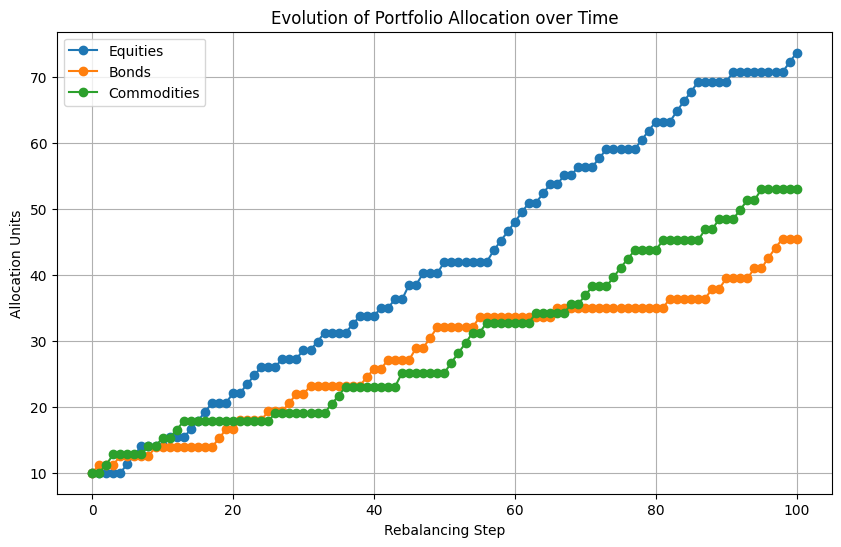

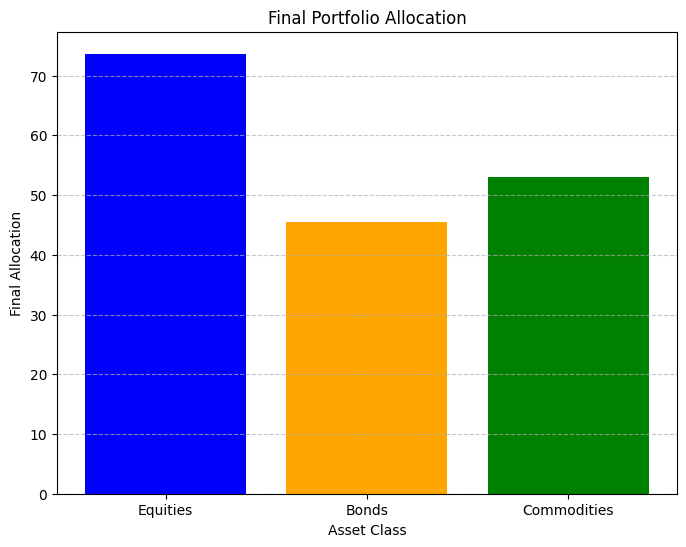

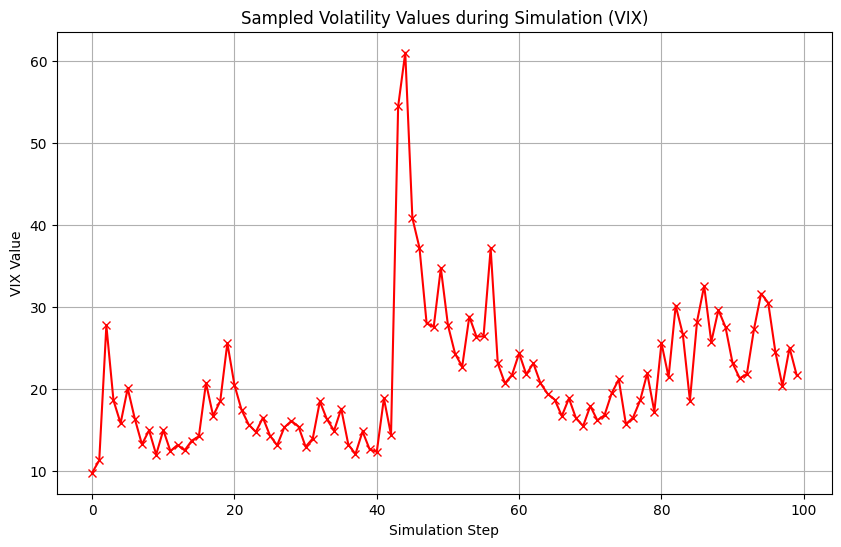

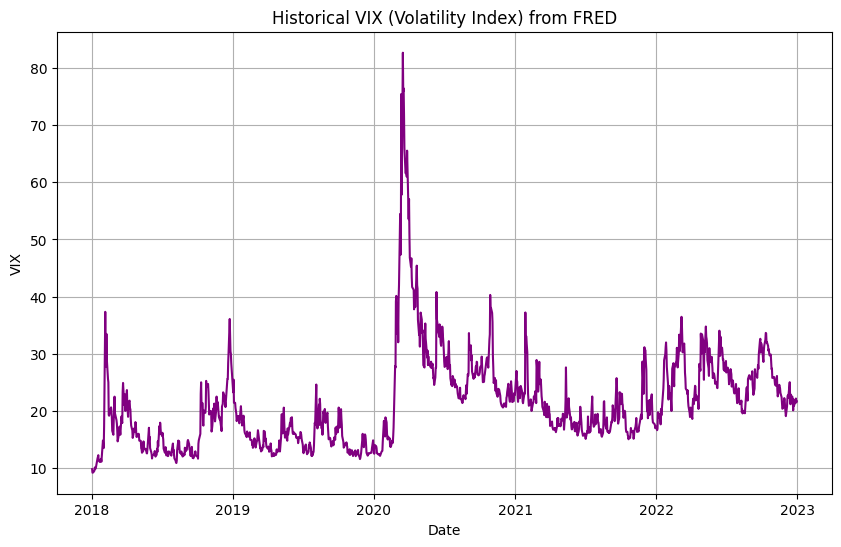

Summary of Portfolio Allocation (First 10 Steps):
      Equities    Bonds  Commodities
Step                                
0      10.0000  10.0000      10.0000
1      10.0000  11.1954      10.0000
2      10.0000  11.1954      11.2254
3      10.0000  11.1954      12.7800
4      10.0000  12.5672      12.7800
5      11.3160  12.5672      12.7800
6      12.7172  12.5672      12.7800
7      14.0440  12.5672      12.7800
8      14.0440  12.5672      14.0446
9      14.0440  13.8660      14.0446


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as web

# -----------------------------
# SETTINGS AND HELPER FUNCTIONS
# -----------------------------

# Function to create folder if not exists
def make_results_folder(folder_name="results"):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

# Simple scaling function f(sigma)
def reinforcement_scaling(sigma, beta=0.02):
    """
    Given a volatility level sigma and parameter beta,
    return the scaling factor for reinforcement.
    """
    return 1 + beta * sigma

# -----------------------------
# DATA FETCHING: VIX Volatility Dataset from FRED
# -----------------------------
def fetch_volatility_data(start_date='2018-01-01', end_date='2023-01-01'):
    """
    Uses FRED (via pandas_datareader) to fetch the VIX index.
    VIXCLS is the closing value of VIX.
    """
    try:
        vix = web.DataReader('VIXCLS', 'fred', start_date, end_date)
        # Drop NaN values and sort by date
        vix = vix.dropna().sort_index()
        vix.rename(columns={'VIXCLS': 'VIX'}, inplace=True)
        return vix
    except Exception as e:
        print("Error fetching data from FRED:", e)
        return None

# -----------------------------
# SIMULATION FUNCTION
# -----------------------------
def simulate_polya_urn_with_volatility(vix_series, n_steps=100,
                                       initial_allocation=np.array([10.0, 10.0, 10.0]),
                                       beta=0.02, seed=42):
    """
    Simulate a portfolio allocation process (3 asset classes) using a Pólya urn model
    where the reinforcement increment is scaled by a volatility measure.

    Parameters:
    - vix_series: a pandas Series with volatility values (assumed to be indexed by date).
    - n_steps: number of discrete time steps (rebalance events).
    - initial_allocation: array for the initial allocation for each asset class.
    - beta: parameter for the reinforcement scaling f(sigma)=1+beta*sigma.
    - seed: random seed for reproducibility.

    Returns:
    - allocations: a numpy array of shape (n_steps+1, n_assets), storing the allocation
                   vector at every step.
    - chosen_asset: list of asset indices drawn at each step.
    - vol_list: list of volatility values used at each step (interpolated from vix_series).
    """
    np.random.seed(seed)
    n_assets = len(initial_allocation)

    # Preallocate arrays to store the evolution
    allocations = np.zeros((n_steps + 1, n_assets))
    allocations[0] = initial_allocation.copy()
    chosen_asset = []
    vol_list = []  # volatility used at each step

    # We have a real volatility series, but we need exactly n_steps values.
    # We therefore sample (or interpolate) from the series.
    # For simplicity, we take n_steps equally spaced points from the vix_series.
    vix_array = vix_series.values.flatten()
    if len(vix_array) < n_steps:
        # If less than needed, repeat or use interpolation
        indices = np.linspace(0, len(vix_array)-1, n_steps, dtype=int)
    else:
        indices = np.linspace(0, len(vix_array)-1, n_steps, dtype=int)
    vol_samples = vix_array[indices]

    # (Optional) Normalize the volatility values to a suitable scale if needed.
    # Here we assume VIX is in a percent scale (often 15-40), so it is used directly.

    current_allocation = initial_allocation.copy()

    for step in range(1, n_steps + 1):
        # Get the volatility for the current step
        sigma = vol_samples[step - 1]  # e.g., VIX value
        vol_list.append(sigma)

        # Compute effective reinforcement factor
        scaling = reinforcement_scaling(sigma, beta=beta)

        # Compute the probabilities for drawing each asset proportional to current allocation
        total = current_allocation.sum()
        probs = current_allocation / total

        # Draw an asset index (0, 1, or 2)
        asset_draw = np.random.choice(np.arange(n_assets), p=probs)
        chosen_asset.append(asset_draw)

        # In this simplified version, we assume the replacement matrix is the identity.
        # Only the drawn asset gets an increment equal to scaling.
        # You can extend this to a full replacement matrix if needed.
        increment = scaling  # Effective increment

        current_allocation = current_allocation.copy()
        current_allocation[asset_draw] += increment

        allocations[step] = current_allocation

    return allocations, chosen_asset, vol_list

# -----------------------------
# PLOTTING FUNCTION
# -----------------------------
def generate_and_save_plots(allocations, vol_list, vix_series, results_folder):
    steps = np.arange(allocations.shape[0])
    n_assets = allocations.shape[1]
    asset_names = ['Equities', 'Bonds', 'Commodities']

    # -----------------------------
    # 1. Time Series Evolution Plot for Portfolio Composition
    plt.figure(figsize=(10, 6))
    for i in range(n_assets):
        plt.plot(steps, allocations[:, i], marker='o', label=asset_names[i])
    plt.title("Evolution of Portfolio Allocation over Time")
    plt.xlabel("Rebalancing Step")
    plt.ylabel("Allocation Units")
    plt.grid(True)
    plt.legend()
    ts_plot_path = os.path.join(results_folder, "portfolio_evolution.png")
    plt.savefig(ts_plot_path, dpi=150)
    plt.show()

    # -----------------------------
    # 2. Bar Chart for Final Allocation
    plt.figure(figsize=(8, 6))
    plt.bar(asset_names, allocations[-1], color=['blue', 'orange', 'green'])
    plt.title("Final Portfolio Allocation")
    plt.xlabel("Asset Class")
    plt.ylabel("Final Allocation")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    bar_plot_path = os.path.join(results_folder, "final_allocation.png")
    plt.savefig(bar_plot_path, dpi=150)
    plt.show()

    # -----------------------------
    # 3. Plot of the Used Volatility (VIX) Series Over Simulation Steps
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(vol_list)), vol_list, marker='x', color='red')
    plt.title("Sampled Volatility Values during Simulation (VIX)")
    plt.xlabel("Simulation Step")
    plt.ylabel("VIX Value")
    plt.grid(True)
    vol_plot_path = os.path.join(results_folder, "sampled_volatility.png")
    plt.savefig(vol_plot_path, dpi=150)
    plt.show()

    # -----------------------------
    # 4. Plot the original VIX time series fetched from FRED
    plt.figure(figsize=(10, 6))
    plt.plot(vix_series.index, vix_series['VIX'], color='purple')
    plt.title("Historical VIX (Volatility Index) from FRED")
    plt.xlabel("Date")
    plt.ylabel("VIX")
    plt.grid(True)
    vix_ts_plot_path = os.path.join(results_folder, "historical_VIX.png")
    plt.savefig(vix_ts_plot_path, dpi=150)
    plt.show()

# -----------------------------
# TABLE DISPLAY FUNCTION
# -----------------------------
def generate_and_save_summary_table(allocations, results_folder):
    n_steps = allocations.shape[0]
    steps = np.arange(n_steps)
    df = pd.DataFrame(allocations, columns=['Equities', 'Bonds', 'Commodities'])
    df.index.name = "Step"
    table_path = os.path.join(results_folder, "allocation_summary.csv")
    df.to_csv(table_path)

    # Also, print the first 10 steps for quick overview.
    print("Summary of Portfolio Allocation (First 10 Steps):")
    print(df.head(10))

    return df

# -----------------------------
# MAIN FUNCTION
# -----------------------------
def main():
    # Create results folder
    results_folder = make_results_folder("results")

    # Fetch real volatility data (VIX from FRED)
    print("Fetching historical VIX data from FRED...")
    vix_data = fetch_volatility_data(start_date='2018-01-01', end_date='2023-01-01')
    if vix_data is None or vix_data.empty:
        print("Failed to fetch VIX data. Exiting simulation.")
        return
    else:
        print("Successfully fetched VIX data. Number of records:", len(vix_data))

    # Simulation parameters
    n_steps = 100  # number of rebalancing steps/draws
    initial_allocation = np.array([10.0, 10.0, 10.0])
    beta = 0.02  # parameter for reinforcement scaling

    # Simulate the stochastic Pólya urn (portfolio allocation) with volatility effect
    allocations, chosen_asset, vol_list = simulate_polya_urn_with_volatility(
        vix_series=vix_data['VIX'],
        n_steps=n_steps,
        initial_allocation=initial_allocation,
        beta=beta,
        seed=42
    )
    print("Simulation completed.")

    # Generate and save plots
    generate_and_save_plots(allocations, vol_list, vix_data, results_folder)

    # Generate and save summary table
    df_summary = generate_and_save_summary_table(allocations, results_folder)

if __name__ == '__main__':
    main()
